In [7]:
! pwd

/Users/nusaybaelali/Documents/fis/analysis


In [8]:
!ls /Users/nusaybaelali/documents/fis/coarsegrainedactin/simulations/box/Boxv5_000_a_FAS.cif

/Users/nusaybaelali/documents/fis/coarsegrainedactin/simulations/box/Boxv5_000_a_FAS.cif


In [9]:
import mdtraj

In [19]:
!pip install prody

In [20]:
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyemma
import mdtraj
import scipy.spatial.distance as sdist
import numpy as np
import prody
import itertools

In [21]:
#List simulation files
data=[]
param_files=glob.glob('/Users/nusaybaelali/documents/fis/coarsegrainedactin/simulations/box/Boxv5_000_a_FAS.param')
for param_file in param_files:
    #Add parameters
    with open(param_file) as param:
        values={}
        for line in param:
            if len(line)==0:
                continue
            line=line.strip().split(',')
            key=line[0]
            value=line[1]
            if key=='':
                continue
            values.update({key:value})
            root='.'.join(param_file.split('.')[:-1])
            values.update({'root':root})
    #Add files
    for extension in ['param','cif','pdb','dcd','log']:
        file_name=f'{root}.{extension}'
        if os.path.exists(file_name):
            values.update({extension:file_name})
    data+=[values]
    
simulations=pd.DataFrame(data)

simulations=simulations.reindex()
simulations=simulations.reset_index(drop=True)
simulations

,epsilon_ABP,root,epsilon_CAM,aligned,actinLen,disorder,box_size,n_actins,n_FAS,n_AAC,...,simulation_platform,test_run,date,name,job_id,param,cif,pdb,dcd,log
0,100,/Users/nusaybaelali/documents/fis/coarsegraine...,100,False,100,0,10000,20,200,200,...,OpenCL,False,2023_06_13,Simulations/Box/Boxv5_000_a_FAS,0,/Users/nusaybaelali/documents/fis/coarsegraine...,/Users/nusaybaelali/documents/fis/coarsegraine...,/Users/nusaybaelali/documents/fis/coarsegraine...,/Users/nusaybaelali/documents/fis/coarsegraine...,/Users/nusaybaelali/documents/fis/coarsegraine...


In [16]:
simulations.columns

Index(['epsilon_ABP', 'root', 'epsilon_CAM', 'aligned', 'actinLen', 'disorder',
       'box_size', 'n_actins', 'n_FAS', 'n_AAC', 'n_CAM', 'temperature',
       'system2D', 'frequency', 'run_time', 'abp', 'simulation_platform',
       'test_run', 'date', 'name', 'job_id', 'param', 'cif', 'pdb', 'dcd',
       'log'],
      dtype='object')

In [22]:
simulations['abp']

0    FAS
Name: abp, dtype: object

In [24]:
stride=1
data={}
for i,simulation in simulations.iterrows():
    
    selected_simulation=simulation

    root=selected_simulation['root']
    dcd=selected_simulation['dcd']
    cif=selected_simulation['cif']

   

In [25]:
cif=prody.parseMMCIF(selected_simulation['cif'])
dcd=prody.parseDCD(selected_simulation['dcd'])
dcd.setAtoms(cif) 
dcd.getCoordsets().shape
n_frames , n_particles, xyz = dcd.getCoordsets().shape

@> WARNING Could not find _atom_site_anisotrop in lines.
@> WARNING No anisotropic B factors found
@> 22160 atoms and 1 coordinate set(s) were parsed in 0.43s.
@> DCD file contains 494 coordinate sets for 22160 atoms.
@> DCD file was parsed in 0.17 seconds.
@> 125.29 MB parsed at input rate 719.43 MB/s.
@> 494 coordinate sets parsed at input rate 2836 frame/s.


In [26]:
coords=dcd.getCoordsets()
coords.shape
coords.reshape(-1,3).shape

(10947040, 3)

In [27]:
df=pd.DataFrame(coords.reshape(-1,3),columns=['x','y','z'])


In [28]:
df['frame'] = np.repeat(np.arange(n_frames), n_particles)


In [29]:
particles , frames = np.meshgrid(np.arange(n_particles), np.arange(n_frames))
# Flatten the arrays to get the combinations
frames = frames.flatten()
particles = particles.flatten()
frames
particles
df['frame'] = frames
df['particle']=particles


In [41]:
df['names']=np.tile(cif.getNames(),n_frames)
df['residue_names']=np.tile(cif.getResnames(),n_frames)
df['chain_id']=np.tile(cif.getChids(),n_frames)
df['atom_element']=np.tile(cif.getElements(),n_frames)

In [46]:
frame=df[df['frame']==df['frame'].max()]

In [108]:
actin=frame[frame['residue_names'].isin(['ACD','ACT']) & frame['names'].isin(['Aa','Ab','Ac'])] 
fascin=frame[frame['residue_names'].isin(['FAS']) & frame['names'].isin(['Ca','Cb','Cd'])]
aactinin=frame[frame['residue_names'].isin(['AAC']) & frame['names'].isin(['Ca','Cb','Cd'])]

In [109]:
xyz1=actin[['x','y','z']].values
xyz2=fascin[['x','y','z']].values
distance=sdist.cdist(xyz1,xyz2)

In [122]:
new_shape = (distance.shape[0] // 3, distance.shape[1] // 3)
reshaped_matrix = distance.reshape(new_shape[0], 3, new_shape[1], 3)

# Compute the average value along the specified axes
averaged_distance = reshaped_matrix.mean(axis=(1, 3)) 


272

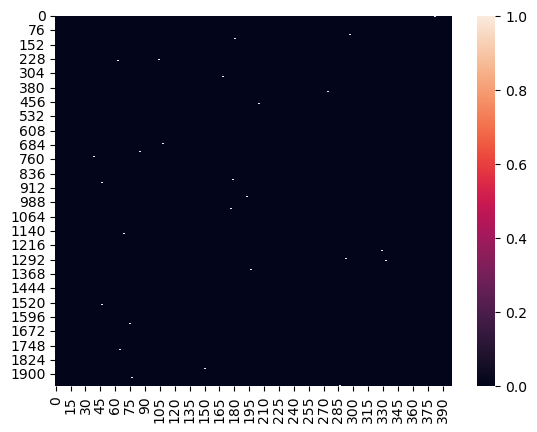

In [162]:
sns.heatmap(averaged_distance<50) #this is a contact map
number_connected_fascin=sum(sum((averaged_distance<50))>0) 
(averaged_distance<50).sum(axis=1).shape
number_connected_fascin

In [ ]:
frame=df[df['frame']==df['frame'].max()]
actin=frame[frame['residue_names'].isin(['ACD','ACT']) & frame['names'].isin(['Aa','Ab','Ac'])] 
fascin=frame[frame['residue_names'].isin(['FAS']) & frame['names'].isin(['Ca','Cb','Cd'])]
aactinin=frame[frame['residue_names'].isin(['AAC']) & frame['names'].isin(['Ca','Cb','Cd'])]
xyz1=actin[['x','y','z']].values
xyz2=fascin[['x','y','z']].values
distance=sdist.cdist(xyz1,xyz2)
new_shape = (distance.shape[0] // 3, distance.shape[1] // 3)
reshaped_matrix = distance.reshape(new_shape[0], 3, new_shape[1], 3)

# Compute the average value along the specified axes
averaged_distance = reshaped_matrix.mean(axis=(1, 3))
sns.heatmap(averaged_distance<50)
number_connected_fascin=sum(sum((averaged_distance<50))>0)
#(averaged_distance<50).sum(axis=1).shape


In [175]:
# actin_filter = df['residue_names'].isin(['ACD', 'ACT']) & df['names'].isin(['Aa', 'Ab', 'Ac'])
# fascin_filter = df['residue_names'].isin(['FAS']) & df['names'].isin(['Ca', 'Cb', 'Cd'])
# aac_filter = df['residue_names'].isin(['AAC']) & df['names'].isin(['Ca', 'Cb', 'Cd'])

# # Apply the filters to the DataFrame
# actin_data = df[actin_filter]
# fascin_data = df[fascin_filter]
# aac_data = df[aac_filter]

# connected_fascin_counts = []

# Group the data by frame and perform computations for each frame
grouped_frames = df.groupby('frame')

df['actin_filter'] = df['residue_names'].isin(['ACD', 'ACT']) & df['names'].isin(['Aa', 'Ab', 'Ac'])
df['fascin_filter'] = df['residue_names'].isin(['FAS']) & df['names'].isin(['Ca', 'Cb', 'Cd'])
df['aac_filter'] = df['residue_names'].isin(['AAC']) & df['names'].isin(['Ca', 'Cb', 'Cd'])
connected_fascin_counts = []
connected_aac_counts = []

# Group the data by frame and perform computations for each frame
for frame_num, frame_group in df.groupby('frame'):
    if frame_num % 20 == 0:
        print(frame_num)
    actin_group = frame_group[frame_group['actin_filter']]
    fascin_group = frame_group[frame_group['fascin_filter']]
    aac_group = frame_group[frame_group['aac_filter']]
    #aac_group = aac_data[aac_data['frame'] == frame_num]
    
    xyz1 = actin_group[['x', 'y', 'z']].values
    xyz2 = fascin_group[['x', 'y', 'z']].values
    xyz3 = aac_group[['x','y','z']].values
    
    distance = sdist.cdist(xyz1, xyz2) 
    new_shape = (distance.shape[0] // 3, distance.shape[1] // 3)
    reshaped_matrix = distance.reshape(new_shape[0], 3, new_shape[1], 3)
    averaged_distance = reshaped_matrix.mean(axis=(1, 3))
    number_connected_fascin = sum(np.any(averaged_distance < 50, axis=0))
    connected_fascin_counts.append(number_connected_fascin)
    
    distance_aac = sdist.cdist(xyz1, xyz3) 
    new_shape_aac = (distance_aac.shape[0] // 3, distance_aac.shape[1] // 3)
    reshaped_matrix_aac = distance_aac.reshape(new_shape_aac[0], 3, new_shape_aac[1], 3)
    averaged_distance_aac = reshaped_matrix_aac.mean(axis=(1, 3))
    number_connected_aac = sum(np.any(averaged_distance_aac < 50, axis=0))
    connected_aac_counts.append(number_connected_aac)
    



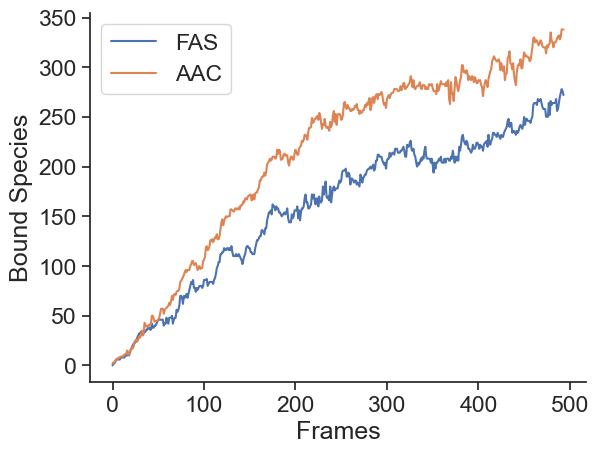

In [186]:
sns.set(style='ticks',font_scale=1.5)
plt.plot(connected_fascin_counts,label='FAS')
plt.plot(connected_aac_counts,label='AAC')
plt.legend()
plt.xlabel('Frames')
plt.ylabel('Bound Species')
sns.despine()


<Axes: >

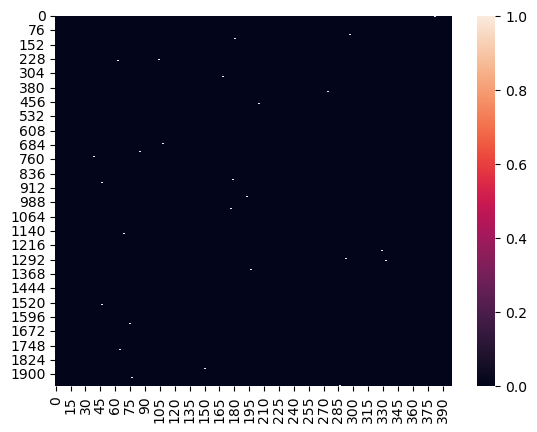

In [165]:
sns.heatmap(averaged_distance<50)